In [1]:
import pandas as pd
import numpy as np
#import ast
#import re
#import math
#import json
#import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import dataprocessing_helper as dph
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
#import time
from sklearn.metrics import accuracy_score, f1_score
%matplotlib inline

In [2]:
# file timestamp prefix without leading dash
TS_PREFIX = '241211-194304-'

# read in the json files
portfolio = pd.read_excel(f'../misc/{TS_PREFIX}portfolio.xlsx')   
portfolio.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
profile = pd.read_excel(f'../misc/{TS_PREFIX}profile.xlsx')   
profile.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
# transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
# Load data from previously generated offer_agg dataframe (stored in XLSX format)
offer_agg = pd.read_excel(f'../misc/{TS_PREFIX}offer_agg.xlsx')   
offer_agg.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [4]:
offer_agg.describe()

,age,became_member_on,income,member_years,offer_rcvd_time,offer_duration,offer_difficulty,offer_reward,offer_trx_amount,offer_cmpl_time,offer_view_time,offer_view_time_el,offer_cmpl_time_el
count,53201.000000,61042,53201.000000,61042.000000,61042.000000,61042.000000,61042.000000,61042.000000,33101.000000,33101.000000,29281.000000,29281.000000,33101.000000
mean,54.321610,2017-02-24 10:11:05.010976,65371.590760,1.361784,332.679270,7.253383,9.631434,5.250254,18.501121,399.413915,343.082340,14.959940,61.313435
min,18.000000,2013-07-29 00:00:00,30000.000000,0.000000,0.000000,5.000000,5.000000,2.000000,0.150000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,2016-05-25 00:00:00,49000.000000,1.000000,168.000000,7.000000,7.000000,3.000000,8.990000,234.000000,174.000000,0.000000,18.000000
50%,55.000000,2017-08-03 00:00:00,64000.000000,1.000000,408.000000,7.000000,10.000000,5.000000,14.840000,432.000000,390.000000,6.000000,48.000000
75%,66.000000,2017-12-31 00:00:00,80000.000000,2.000000,504.000000,10.000000,10.000000,5.000000,21.850000,558.000000,510.000000,18.000000,90.000000
max,101.000000,2018-07-26 00:00:00,120000.000000,5.000000,576.000000,10.000000,20.000000,10.000000,1015.730000,714.000000,708.000000,222.000000,240.000000
std,17.384883,NaN,21639.081109,1.179076,196.409084,1.783308,4.449554,2.988313,37.023428,192.831514,196.303597,21.518966,50.676774


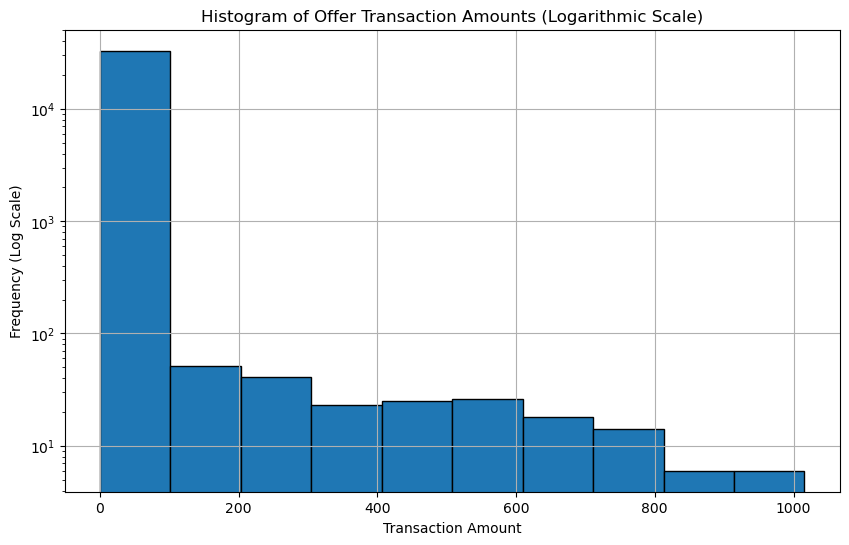

In [5]:
# Create a histogram for the values of 'offer_trx_amount' with a logarithmic scale
plt.figure(figsize=(10, 6))
plt.hist(offer_agg['offer_trx_amount'], bins=10, edgecolor='black', log=True)
plt.title('Histogram of Offer Transaction Amounts (Logarithmic Scale)')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency (Log Scale)')
plt.grid(True)
plt.show()

In [6]:
offer_agg['offer_trx_amount'].nsmallest(10)

30129    0.15
49010    0.15
51925    0.15
16072    0.23
37704    0.23
36179    0.29
45298    0.29
4839     0.34
44412    0.34
59114    0.35
Name: offer_trx_amount, dtype: float64

In [7]:
offer_agg['offer_trx_amount'].nlargest(10)

55913    1015.73
24891     989.34
38315     966.24
30769     936.94
3986      920.01
24084     919.16
49958     881.35
28747     871.51
42419     841.45
20512     841.06
Name: offer_trx_amount, dtype: float64

In [8]:
offer_agg.describe()

,age,became_member_on,income,member_years,offer_rcvd_time,offer_duration,offer_difficulty,offer_reward,offer_trx_amount,offer_cmpl_time,offer_view_time,offer_view_time_el,offer_cmpl_time_el
count,53201.000000,61042,53201.000000,61042.000000,61042.000000,61042.000000,61042.000000,61042.000000,33101.000000,33101.000000,29281.000000,29281.000000,33101.000000
mean,54.321610,2017-02-24 10:11:05.010976,65371.590760,1.361784,332.679270,7.253383,9.631434,5.250254,18.501121,399.413915,343.082340,14.959940,61.313435
min,18.000000,2013-07-29 00:00:00,30000.000000,0.000000,0.000000,5.000000,5.000000,2.000000,0.150000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,2016-05-25 00:00:00,49000.000000,1.000000,168.000000,7.000000,7.000000,3.000000,8.990000,234.000000,174.000000,0.000000,18.000000
50%,55.000000,2017-08-03 00:00:00,64000.000000,1.000000,408.000000,7.000000,10.000000,5.000000,14.840000,432.000000,390.000000,6.000000,48.000000
75%,66.000000,2017-12-31 00:00:00,80000.000000,2.000000,504.000000,10.000000,10.000000,5.000000,21.850000,558.000000,510.000000,18.000000,90.000000
max,101.000000,2018-07-26 00:00:00,120000.000000,5.000000,576.000000,10.000000,20.000000,10.000000,1015.730000,714.000000,708.000000,222.000000,240.000000
std,17.384883,NaN,21639.081109,1.179076,196.409084,1.783308,4.449554,2.988313,37.023428,192.831514,196.303597,21.518966,50.676774


In [9]:
# For analysis of average revenue per offer receivded for various customer groups, remove outlier the table regarding offer_trx_amount and remove records having gender = 'O'
Q1 = offer_agg['offer_trx_amount'].quantile(0.25)
Q3 = offer_agg['offer_trx_amount'].quantile(0.75)
IQR = Q3 - Q1
offer_agg_iqr = offer_agg[(offer_agg['offer_trx_amount'] >= (Q1 - 1.5 * IQR)) & (offer_agg['offer_trx_amount'] <= (Q3 + 1.5 * IQR))]
offer_agg_iqr = offer_agg_iqr[offer_agg_iqr['gender'] != 'O']
offer_agg_iqr.describe()

,age,became_member_on,income,member_years,offer_rcvd_time,offer_duration,offer_difficulty,offer_reward,offer_trx_amount,offer_cmpl_time,offer_view_time,offer_view_time_el,offer_cmpl_time_el
count,30994.000000,32044,30994.000000,32044.000000,32044.000000,32044.000000,32044.000000,32044.000000,32044.000000,32044.000000,22498.000000,22498.000000,32044.000000
mean,55.821223,2016-12-11 04:27:17.548370944,69435.632703,1.575646,338.391462,7.316315,9.223099,4.897922,15.629968,399.819561,346.269179,18.382967,61.428099
min,18.000000,2013-07-29 00:00:00,30000.000000,0.000000,0.000000,5.000000,5.000000,2.000000,0.150000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,2016-03-21 00:00:00,53000.000000,1.000000,168.000000,7.000000,5.000000,2.000000,8.830000,234.000000,180.000000,0.000000,18.000000
50%,57.000000,2017-02-14 00:00:00,69000.000000,1.000000,408.000000,7.000000,10.000000,5.000000,14.630000,432.000000,390.000000,12.000000,48.000000
75%,67.000000,2017-10-26 00:00:00,85000.000000,2.000000,504.000000,10.000000,10.000000,5.000000,21.440000,558.000000,510.000000,24.000000,90.000000
max,101.000000,2018-07-26 00:00:00,120000.000000,5.000000,576.000000,10.000000,20.000000,10.000000,41.120000,714.000000,708.000000,222.000000,240.000000
std,16.819864,NaN,21549.213493,1.124934,192.120028,1.769244,4.140527,2.885692,8.513229,192.702724,195.355455,22.905862,50.770655


In [10]:
'''
# Define the custom order for income_range
income_order = ['25000-49999', '50000-74999', '75000-99999', '100000+']

# Convert the income_range column to a categorical type with the specified order
offer_agg_iqr['income_range'] = pd.Categorical(offer_agg_iqr['income_range'], categories=income_order, ordered=True)
'''

"\n# Define the custom order for income_range\nincome_order = ['25000-49999', '50000-74999', '75000-99999', '100000+']\n\n# Convert the income_range column to a categorical type with the specified order\noffer_agg_iqr['income_range'] = pd.Categorical(offer_agg_iqr['income_range'], categories=income_order, ordered=True)\n"

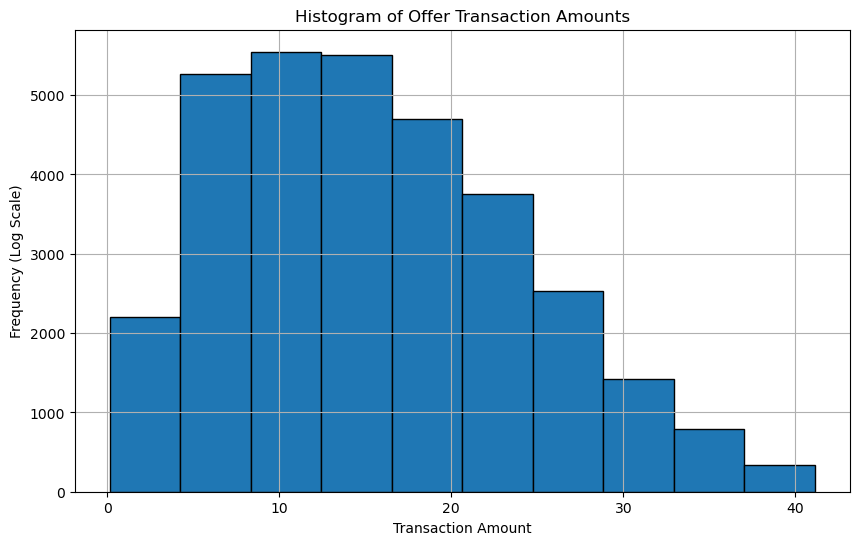

In [ ]:
# Create a histogram for the values of 'offer_trx_amount' (IQR cleaned)
plt.figure(figsize=(10, 6))
plt.hist(offer_agg_iqr['offer_trx_amount'], bins=10, edgecolor='black')
plt.title('Histogram of Offer Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

 # Exploratory Data Analysis

In [12]:
# Group dataframe offer_agg by 'offer_id' and aggregate the required columns
result = offer_agg.groupby('offer_id').agg({
    'offer_rcvd_time': 'count',
    'offer_view_time': 'count',
    'offer_cmpl_time': 'count',
    'offer_trx_amount': 'sum'
}).reset_index()

print(result.columns)

# Rename columns to match the desired names
result.rename(columns={
    'offer_rcvd_time': 'count_offer_rcvd',
    'offer_view_time': 'count_offer_view',
    'offer_cmpl_time': 'count_offer_cmpl',
    'offer_trx_amount': 'sum_offer_trx_amount'
}, inplace=True)


result['trx_amount_per_offer_rcvd'] = result['sum_offer_trx_amount'] / result['count_offer_rcvd']
result['trx_amount_per_offer_compl'] = result['sum_offer_trx_amount'] / result['count_offer_cmpl']

Index(['offer_id', 'offer_rcvd_time', 'offer_view_time', 'offer_cmpl_time',
       'offer_trx_amount'],
      dtype='object')


In [13]:
result

,offer_id,count_offer_rcvd,count_offer_view,count_offer_cmpl,sum_offer_trx_amount,trx_amount_per_offer_rcvd,trx_amount_per_offer_compl
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,1517,3313,78176.26,10.195130,23.596819
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,5379,5102,80316.50,10.504381,15.742160
2,2906b810c7d4411798c6938adc9daaa5,7632,2514,3955,73332.37,9.608539,18.541686
3,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,3760,3301,72103.68,9.496073,21.842981
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,2514,4303,67170.61,8.749591,15.610181
5,ae264e3637204a6fb9bb56bc8210ddfd,7658,3767,3635,79209.36,10.343348,21.790746
6,f19421c1d4aa40978ebb69ca19b0e20d,7571,4290,4262,74330.04,9.817731,17.440178
7,fafdcd668e3743c1bb461111dcafc2a4,7597,5540,5230,87766.79,11.552822,16.781413


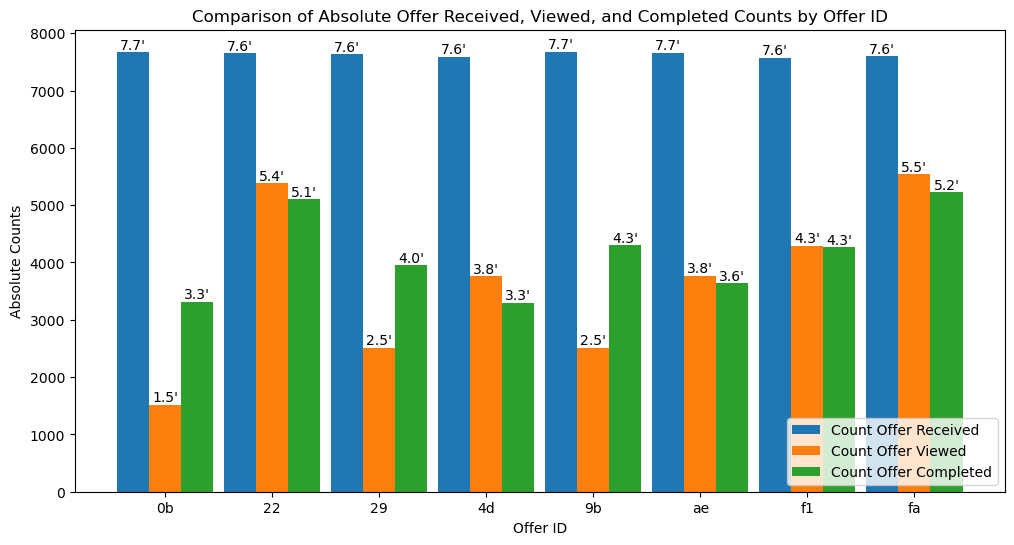

In [14]:
# Create a bar graph to compare absolute values of count_offer_rcvd, count_offer_view, count_offer_cmpl for each offer_id

# Set the figure size
plt.figure(figsize=(12, 6))

# Set the positions and width for the bars
positions = range(len(result))
width = 0.3

# Plot the bars
bars1 = plt.bar(positions, result['count_offer_rcvd'], width=width, label='Count Offer Received')
bars2 = plt.bar([p + width for p in positions], result['count_offer_view'], width=width, label='Count Offer Viewed')
bars3 = plt.bar([p + width * 2 for p in positions], result['count_offer_cmpl'], width=width, label='Count Offer Completed')

# Add the values on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval/1000:.1f}'", ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval/1000:.1f}'", ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval/1000:.1f}'", ha='center', va='bottom')

# Set the x-axis labels and positions
plt.xlabel('Offer ID')
plt.ylabel('Absolute Counts')
plt.title('Comparison of Absolute Offer Received, Viewed, and Completed Counts by Offer ID')
plt.xticks([p + width for p in positions], result['offer_id'].str[:2])

# Add legend and move it to the bottom right corner
plt.legend(loc='lower right')

# Show the plot
plt.show()

### Absolute counts of offer received, offer viewed and offer completed

*Distribution of offer ids in transcript dataset:* <br>
*As the bar graphs above are showing the various offers are nearly evenly distributed in the transcript data set.*
<br><br>
*Count offer views vs. count offer completed anomaly:* <br>
*For offers '0b', '29', '9b' there are many offers, which are not viewed prior to their completion. This was already detected in the test data (see discusion above).*

In [15]:
portfolio['reward_difficulty_quotient'] = round(portfolio['reward'] / portfolio['difficulty'], 2)
portfolio

,reward,channels,difficulty,duration,offer_type,id,duration_hours,reward_difficulty_quotient
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,168,1.00
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,120,1.00
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,96,NaN
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,1.00
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,240,0.25
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,168,0.43
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,240,0.20
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,72,NaN
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,120,1.00
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,168,0.20


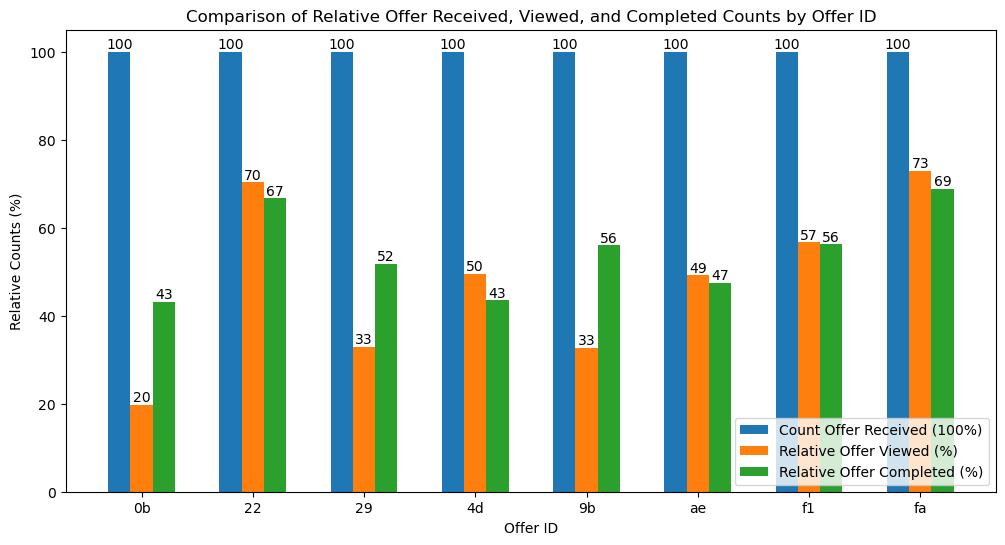

In [16]:
import matplotlib.pyplot as plt

# Create a bar graph to compare count_offer_view, count_offer_cmpl for each offer_id relatively to count_offer_rcvd

# Calculate relative values where count_offer_rcvd is 100%
result['relative_offer_view'] = (result['count_offer_view'] / result['count_offer_rcvd']) * 100
result['relative_offer_cmpl'] = (result['count_offer_cmpl'] / result['count_offer_rcvd']) * 100

# Set the figure size
plt.figure(figsize=(12, 6))

# Set the positions and width for the bars
positions = range(len(result))
width = 0.2

# Plot the bars
bars1 = plt.bar(positions, [100] * len(result), width=width, label='Count Offer Received (100%)')
bars2 = plt.bar([p + width for p in positions], result['relative_offer_view'], width=width, label='Relative Offer Viewed (%)')
bars3 = plt.bar([p + width * 2 for p in positions], result['relative_offer_cmpl'], width=width, label='Relative Offer Completed (%)')

# Add the values on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom')

# Set the x-axis labels and positions
plt.xlabel('Offer ID')
plt.ylabel('Relative Counts (%)')
plt.title('Comparison of Relative Offer Received, Viewed, and Completed Counts by Offer ID')
plt.xticks([p + width for p in positions], result['offer_id'].str[:2])

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [17]:
result

,offer_id,count_offer_rcvd,count_offer_view,count_offer_cmpl,sum_offer_trx_amount,trx_amount_per_offer_rcvd,trx_amount_per_offer_compl,relative_offer_view,relative_offer_cmpl
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,1517,3313,78176.26,10.195130,23.596819,19.783516,43.205529
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,5379,5102,80316.50,10.504381,15.742160,70.350510,66.727701
2,2906b810c7d4411798c6938adc9daaa5,7632,2514,3955,73332.37,9.608539,18.541686,32.940252,51.821279
3,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,3760,3301,72103.68,9.496073,21.842981,49.519294,43.474253
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,2514,4303,67170.61,8.749591,15.610181,32.747167,56.050541
5,ae264e3637204a6fb9bb56bc8210ddfd,7658,3767,3635,79209.36,10.343348,21.790746,49.190389,47.466701
6,f19421c1d4aa40978ebb69ca19b0e20d,7571,4290,4262,74330.04,9.817731,17.440178,56.663585,56.293752
7,fafdcd668e3743c1bb461111dcafc2a4,7597,5540,5230,87766.79,11.552822,16.781413,72.923522,68.842964


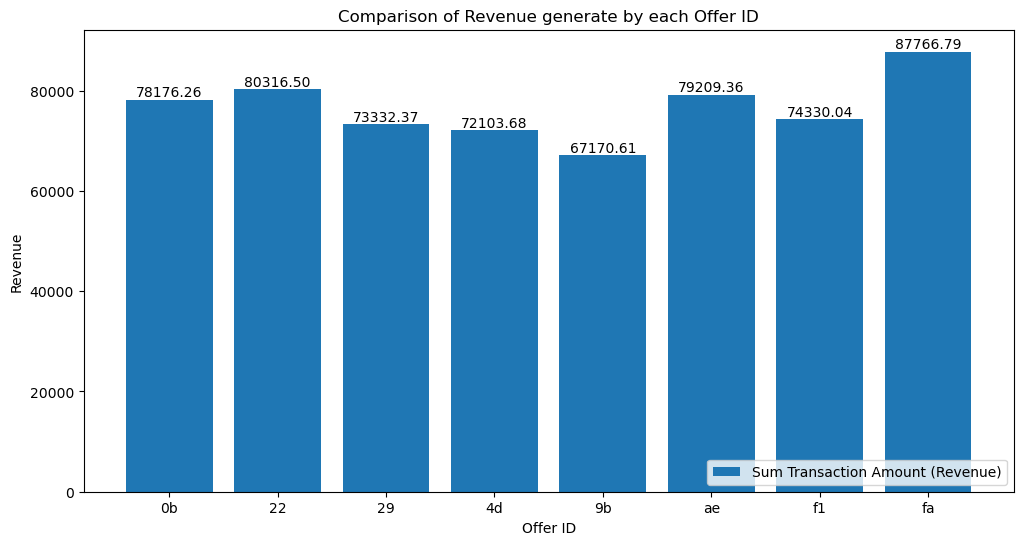

In [18]:
# Create a bar graph to show a comparison of total revenues generate by each offer

# Set the figure size
plt.figure(figsize=(12, 6))

# Set the positions and width for the bars
positions = range(len(result))
# width = 0.2

# Plot the bars
plt.bar(positions, result['sum_offer_trx_amount'], label='Sum Transaction Amount (Revenue)')

# Add the values on top of each bar
for i, value in enumerate(result['sum_offer_trx_amount']):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

# Set the x-axis labels and positions
plt.xlabel('Offer ID')
plt.ylabel('Revenue')
plt.title('Comparison of Revenue generated by offers')
plt.xticks([p for p in positions], result['offer_id'].str[:2])

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show() 

### Overall performance of offers based on absolute revenue and relative completion rate

*Relative completion rate:* <br>
*As the bar graphs above are showing the most successful offers regarding relative completion rate are the offers starting with ID 'fa', '22' and '9b'/'f1'.*
<br><br>
*Absolute revenue:* <br>
*Regarding absolute revenue generated the offers 'fa', 'ae' and '22' are the most successful. It is interesting, that offer 'ae' as a relatively low completion rate (47%), but generates the second highest revenue.*

In [19]:
portfolio['reward_difficulty_quotient'] = round(portfolio['reward'] / portfolio['difficulty'], 2)
portfolio

,reward,channels,difficulty,duration,offer_type,id,duration_hours,reward_difficulty_quotient
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,168,1.00
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,120,1.00
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,96,NaN
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,1.00
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,240,0.25
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,168,0.43
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,240,0.20
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,72,NaN
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,120,1.00
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,168,0.20


In [20]:
profile[(profile['gender'].isna()) & (profile['income'].isna()) & (profile['age'] == 118)]

,gender,age,id,became_member_on,income,age_group,income_range,member_years


In [21]:
# Group dataframe offer_agg by 'offer_id' and aggregate the required columns
result = offer_agg.groupby(['offer_id']).agg({
    'offer_rcvd_time': 'count',
    'offer_view_time': 'count',
    'offer_cmpl_time': 'count',
    'offer_trx_amount': 'sum'
}).reset_index()

# Rename columns to match the desired names
result.rename(columns={
    'offer_rcvd_time': 'count_offer_rcvd',
    'offer_view_time': 'count_offer_view',
    'offer_cmpl_time': 'count_offer_cmpl',
    'offer_trx_amount': 'sum_offer_trx_amount'
}, inplace=True)

print(result.columns)



result['trx_amount_per_offer_rcvd'] = result['sum_offer_trx_amount'] / result['count_offer_rcvd']
result['trx_amount_per_offer_compl'] = result['sum_offer_trx_amount'] / result['count_offer_cmpl']

Index(['offer_id', 'count_offer_rcvd', 'count_offer_view', 'count_offer_cmpl',
       'sum_offer_trx_amount'],
      dtype='object')


In [22]:
result

,offer_id,count_offer_rcvd,count_offer_view,count_offer_cmpl,sum_offer_trx_amount,trx_amount_per_offer_rcvd,trx_amount_per_offer_compl
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,1517,3313,78176.26,10.195130,23.596819
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,5379,5102,80316.50,10.504381,15.742160
2,2906b810c7d4411798c6938adc9daaa5,7632,2514,3955,73332.37,9.608539,18.541686
3,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,3760,3301,72103.68,9.496073,21.842981
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,2514,4303,67170.61,8.749591,15.610181
5,ae264e3637204a6fb9bb56bc8210ddfd,7658,3767,3635,79209.36,10.343348,21.790746
6,f19421c1d4aa40978ebb69ca19b0e20d,7571,4290,4262,74330.04,9.817731,17.440178
7,fafdcd668e3743c1bb461111dcafc2a4,7597,5540,5230,87766.79,11.552822,16.781413


# Analyse customer segments by pivot table

In [23]:
df_sum_revenue = pd.pivot_table(
    offer_agg_iqr,
    values='offer_trx_amount',  # The values to aggregate
    index=['gender', 'income_range'],        # Rows
    columns=['age_group'],    # Columns
    aggfunc='sum',          # Aggregation function
    fill_value=0,            # Fill missing values with 0
    observed=False
)

df_sum_revenue

age_group             18-27    28-37     38-47     48-57     58-67     68-77  \
gender income_range                                                            
F      100000+         0.00     0.00    103.26    903.19  15721.21  13961.72   
       25000-49999   115.65  3545.21   4281.08   3055.88   3668.43   2889.50   
       50000-74999   270.76  6502.03   8354.47  15375.70  20915.17  18540.33   
       75000-99999     0.00   220.58   1826.81   9694.21  32548.30  29506.04   
M      100000+         0.00     0.00     71.45    414.92   8111.95   6693.56   
       25000-49999   530.45  5536.71   5676.36   5470.01   5182.19   5187.47   
       50000-74999   443.66  7945.86  10225.83  18126.14  23232.47  19687.57   
       75000-99999     0.00   176.32   1890.99  11704.96  25054.36  21484.45   

age_group                 78-  
gender income_range            
F      100000+        9615.83  
       25000-49999    2321.06  
       50000-74999   10454.30  
       75000-99999   17354.66  
M      100000+        4563.05  
       25000-49999    2969.77  
       50000-74999   10858.89  
       75000-99999   14408.28

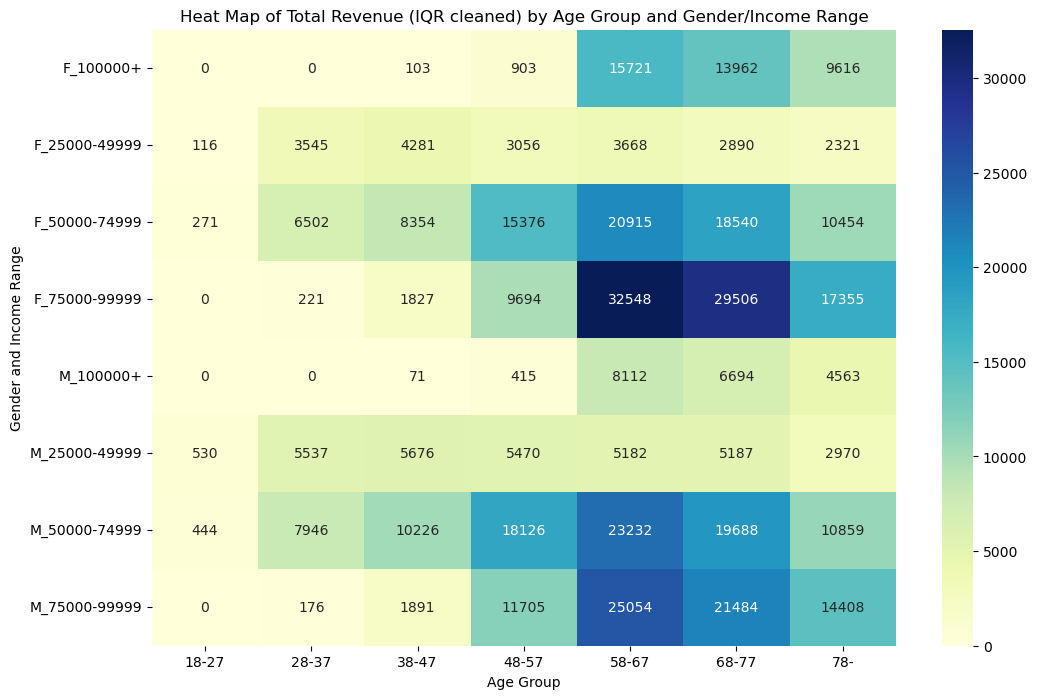

In [24]:
# Reset the index to use numeric values
df_sum_revenue = df_sum_revenue.reset_index()

# Convert categorical data to a single string column for heatmap
df_sum_revenue['gender_income'] = df_sum_revenue['gender'] + '_' + df_sum_revenue['income_range']
df_sum_revenue = df_sum_revenue.drop(columns=['gender', 'income_range'])

# Set the new index
df_sum_revenue = df_sum_revenue.set_index('gender_income')

# Generate a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_sum_revenue, annot=True, fmt=".0f", cmap="YlGnBu")

# Add title and labels
plt.title('Heat Map of Total Revenue (IQR cleaned) by Age Group and Gender/Income Range')
plt.xlabel('Age Group')
plt.ylabel('Gender and Income Range')

# Show the plot
plt.show()


In [25]:
offer_agg.tail(5)

,gender,age,became_member_on,income,age_group,income_range,member_years,person,offer_rcvd_time,offer_id,offer_type,offer_channels,offer_duration,offer_difficulty,offer_reward,offer_trx_amount,offer_cmpl_time,offer_view_time,offer_view_time_el,offer_cmpl_time_el
61037,F,83.0,2016-03-07,50000.0,NaN,50000-74999,2,9dc1421481194dcd9400aec7c9ae6366,336,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,"['web', 'email', 'mobile', 'social']",5,10,10,10.75,360.0,342.0,6.0,24.0
61038,F,83.0,2016-03-07,50000.0,NaN,50000-74999,2,9dc1421481194dcd9400aec7c9ae6366,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,"['web', 'email', 'mobile']",7,5,5,11.03,414.0,NaN,NaN,6.0
61039,F,83.0,2016-03-07,50000.0,NaN,50000-74999,2,9dc1421481194dcd9400aec7c9ae6366,576,ae264e3637204a6fb9bb56bc8210ddfd,bogo,"['email', 'mobile', 'social']",7,10,10,12.57,594.0,NaN,NaN,18.0
61040,F,62.0,2017-07-22,82000.0,68-77,75000-99999,1,e4052622e5ba45a8b96b59aba68cf068,0,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,"['web', 'email', 'mobile', 'social']",7,7,3,21.55,54.0,6.0,6.0,54.0
61041,F,62.0,2017-07-22,82000.0,68-77,75000-99999,1,e4052622e5ba45a8b96b59aba68cf068,408,f19421c1d4aa40978ebb69ca19b0e20d,bogo,"['web', 'email', 'mobile', 'social']",5,5,5,30.57,480.0,NaN,NaN,72.0


In [26]:
# xx
offer_agg_iqr.columns

Index(['gender', 'age', 'became_member_on', 'income', 'age_group',
       'income_range', 'member_years', 'person', 'offer_rcvd_time', 'offer_id',
       'offer_type', 'offer_channels', 'offer_duration', 'offer_difficulty',
       'offer_reward', 'offer_trx_amount', 'offer_cmpl_time',
       'offer_view_time', 'offer_view_time_el', 'offer_cmpl_time_el'],
      dtype='object')

In [27]:
df_count_offer_rcvd = pd.pivot_table(
    offer_agg_iqr,
    values='offer_rcvd_time',  # The values to aggregate
    index=['gender', 'income_range'],        # Rows
    columns=['age_group'],    # Columns
    aggfunc='count',          # Aggregation function
    fill_value=0,            # Fill missing values with 0
    observed=False
)

# Reset the index to use numeric values
df_count_offer_rcvd = df_count_offer_rcvd.reset_index()

# Convert categorical data to a single string column for heatmap
df_count_offer_rcvd['gender_income'] = df_count_offer_rcvd['gender'] + '_' + df_count_offer_rcvd['income_range']
df_count_offer_rcvd = df_count_offer_rcvd.drop(columns=['gender', 'income_range'])

# Set the new index
df_count_offer_rcvd = df_count_offer_rcvd.set_index('gender_income')

df_count_offer_rcvd

age_group,18-27,28-37,38-47,48-57,58-67,68-77,78-
gender_income,,,,,,,
F_100000+,0,0,4,40,653,603,393
F_25000-49999,14,349,413,292,350,295,235
F_50000-74999,16,502,595,1010,1371,1217,674
F_75000-99999,0,11,88,451,1547,1398,830
M_100000+,0,0,3,18,332,284,192
M_25000-49999,53,640,649,612,582,587,339
M_50000-74999,42,734,863,1335,1704,1444,813
M_75000-99999,0,14,98,569,1239,1043,672


In [28]:
df_sum_revenue

age_group,18-27,28-37,38-47,48-57,58-67,68-77,78-
gender_income,,,,,,,
F_100000+,0.00,0.00,103.26,903.19,15721.21,13961.72,9615.83
F_25000-49999,115.65,3545.21,4281.08,3055.88,3668.43,2889.50,2321.06
F_50000-74999,270.76,6502.03,8354.47,15375.70,20915.17,18540.33,10454.30
F_75000-99999,0.00,220.58,1826.81,9694.21,32548.30,29506.04,17354.66
M_100000+,0.00,0.00,71.45,414.92,8111.95,6693.56,4563.05
M_25000-49999,530.45,5536.71,5676.36,5470.01,5182.19,5187.47,2969.77
M_50000-74999,443.66,7945.86,10225.83,18126.14,23232.47,19687.57,10858.89
M_75000-99999,0.00,176.32,1890.99,11704.96,25054.36,21484.45,14408.28


In [29]:
df_avg_revenue_by_offer = df_sum_revenue / df_count_offer_rcvd
df_avg_revenue_by_offer

age_group,18-27,28-37,38-47,48-57,58-67,68-77,78-
gender_income,,,,,,,
F_100000+,NaN,NaN,25.815000,22.579750,24.075360,23.153765,24.467761
F_25000-49999,8.260714,10.158195,10.365811,10.465342,10.481229,9.794915,9.876851
F_50000-74999,16.922500,12.952251,14.041126,15.223465,15.255412,15.234454,15.510831
F_75000-99999,NaN,20.052727,20.759205,21.494922,21.039625,21.105894,20.909229
M_100000+,NaN,NaN,23.816667,23.051111,24.433584,23.568873,23.765885
M_25000-49999,10.008491,8.651109,8.746317,8.937925,8.904107,8.837257,8.760383
M_50000-74999,10.563333,10.825422,11.849166,13.577633,13.634079,13.634051,13.356568
M_75000-99999,NaN,12.594286,19.295816,20.571107,20.221437,20.598706,21.440893


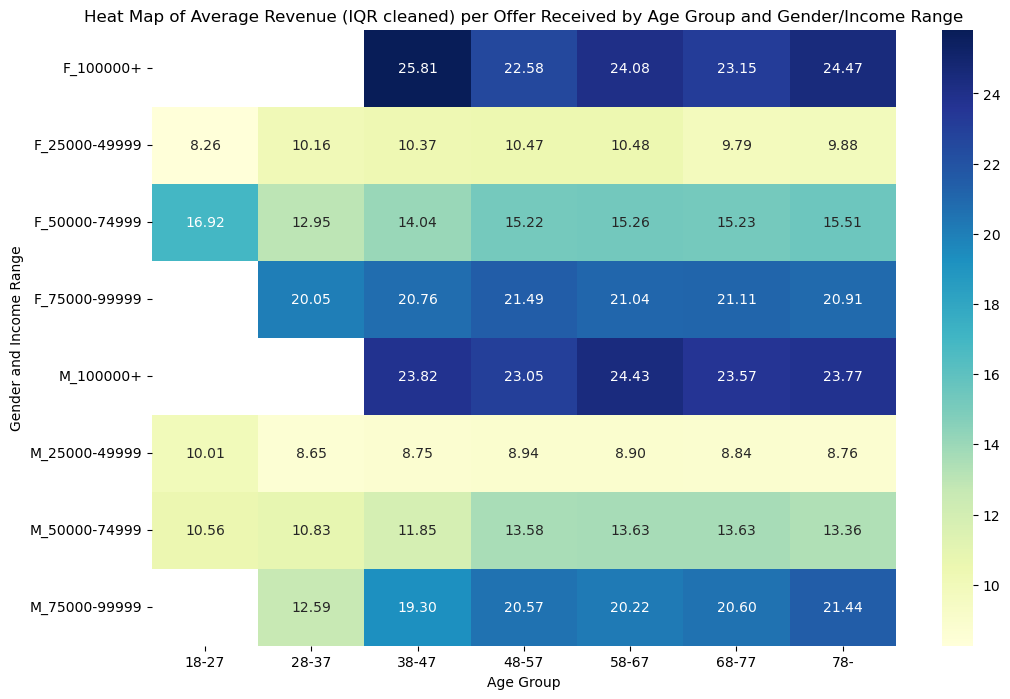

In [30]:
# Generate a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_avg_revenue_by_offer, annot=True, fmt=".2f", cmap="YlGnBu")

# Add title and labels
plt.title('Heat Map of Average Revenue (IQR cleaned) per Offer Received by Age Group and Gender/Income Range')
plt.xlabel('Age Group')
plt.ylabel('Gender and Income Range')

# Show the plot
plt.show()

In [31]:
import pandas as pd

# Define the custom order for income_range
income_order = ['25000-49999', '50000-74999', '75000-99999', '100000+']

# Convert the income_range column to a categorical type with the specified order
offer_agg_iqr['income_range'] = pd.Categorical(offer_agg_iqr['income_range'], categories=income_order, ordered=True)

# Create the pivot table with the custom order
df_sum_revenue = pd.pivot_table(
    offer_agg_iqr,
    values='offer_trx_amount',  # The values to aggregate
    index=['gender', 'income_range'],  # Rows
    columns=['age_group'],  # Columns
    aggfunc='sum',  # Aggregation function
    fill_value=0,  # Fill missing values with 0
    observed=False
)

# Display the pivot table
print(df_sum_revenue)

age_group             18-27    28-37     38-47     48-57     58-67     68-77  \
gender income_range                                                            
F      25000-49999   115.65  3545.21   4281.08   3055.88   3668.43   2889.50   
       50000-74999   270.76  6502.03   8354.47  15375.70  20915.17  18540.33   
       75000-99999     0.00   220.58   1826.81   9694.21  32548.30  29506.04   
       100000+         0.00     0.00    103.26    903.19  15721.21  13961.72   
M      25000-49999   530.45  5536.71   5676.36   5470.01   5182.19   5187.47   
       50000-74999   443.66  7945.86  10225.83  18126.14  23232.47  19687.57   
       75000-99999     0.00   176.32   1890.99  11704.96  25054.36  21484.45   
       100000+         0.00     0.00     71.45    414.92   8111.95   6693.56   

age_group                 78-  
gender income_range            
F      25000-49999    2321.06  
       50000-74999   10454.30  
       75000-99999   17354.66  
       100000+        9615.83  
M      

# Encode offer_agg data

In [32]:
# One hot enccode categorical columns
'''
offer_agg = split_strlist_into_cols(offer_agg, 'offer_channels')
offer_agg = one_hot_encode(offer_agg, 'offer_type')
offer_agg = one_hot_encode(offer_agg, 'gender')
offer_agg = one_hot_encode(offer_agg, 'age_group')
# became_member_on
offer_agg['became_member_year'] = offer_agg['became_member_on'].apply(lambda x: str(x.year))
offer_agg = one_hot_encode(offer_agg, 'became_member_year')
offer_agg.drop(['became_member_year'], axis=1, inplace=True)
'''


"\noffer_agg = split_strlist_into_cols(offer_agg, 'offer_channels')\noffer_agg = one_hot_encode(offer_agg, 'offer_type')\noffer_agg = one_hot_encode(offer_agg, 'gender')\noffer_agg = one_hot_encode(offer_agg, 'age_group')\n# became_member_on\noffer_agg['became_member_year'] = offer_agg['became_member_on'].apply(lambda x: str(x.year))\noffer_agg = one_hot_encode(offer_agg, 'became_member_year')\noffer_agg.drop(['became_member_year'], axis=1, inplace=True)\n"

In [33]:
offer_agg.columns

Index(['gender', 'age', 'became_member_on', 'income', 'age_group',
       'income_range', 'member_years', 'person', 'offer_rcvd_time', 'offer_id',
       'offer_type', 'offer_channels', 'offer_duration', 'offer_difficulty',
       'offer_reward', 'offer_trx_amount', 'offer_cmpl_time',
       'offer_view_time', 'offer_view_time_el', 'offer_cmpl_time_el'],
      dtype='object')

In [34]:
# Reorder columns
'''
offer_agg = offer_agg[['person', 'gender', 'gender_M', 'gender_F', 'age', 'age_group', 
       'age_group_18-27',  
       'age_group_28-37', 
       'age_group_38-47',  
       'age_group_48-57', 
       'age_group_58-67', 
       'age_group_68-77',
       'age_group_78-', 
       'became_member_on', 'member_years', 'became_member_year_2013', 'became_member_year_2014',
       'became_member_year_2015', 'became_member_year_2016',
       'became_member_year_2017', 'became_member_year_2018', 
       'income', 'income_range',
       'offer_rcvd_time', 'offer_view_time', 'offer_view_time_el', 'offer_cmpl_time', 
       'offer_cmpl_time_el', 'offer_id', 'offer_duration', 'offer_difficulty',
       'offer_reward', 'offer_channels', 'offer_channels_web', 'offer_channels_email', 'offer_channels_mobile',
       'offer_channels_social', 'offer_type', 'offer_type_bogo', 'offer_type_discount', 'offer_trx_amount']]
'''

"\noffer_agg = offer_agg[['person', 'gender', 'gender_M', 'gender_F', 'age', 'age_group', \n       'age_group_18-27',  \n       'age_group_28-37', \n       'age_group_38-47',  \n       'age_group_48-57', \n       'age_group_58-67', \n       'age_group_68-77',\n       'age_group_78-', \n       'became_member_on', 'member_years', 'became_member_year_2013', 'became_member_year_2014',\n       'became_member_year_2015', 'became_member_year_2016',\n       'became_member_year_2017', 'became_member_year_2018', \n       'income', 'income_range',\n       'offer_rcvd_time', 'offer_view_time', 'offer_view_time_el', 'offer_cmpl_time', \n       'offer_cmpl_time_el', 'offer_id', 'offer_duration', 'offer_difficulty',\n       'offer_reward', 'offer_channels', 'offer_channels_web', 'offer_channels_email', 'offer_channels_mobile',\n       'offer_channels_social', 'offer_type', 'offer_type_bogo', 'offer_type_discount', 'offer_trx_amount']]\n"

In [35]:
offer_agg_iqr

,gender,age,became_member_on,income,age_group,income_range,member_years,person,offer_rcvd_time,offer_id,offer_type,offer_channels,offer_duration,offer_difficulty,offer_reward,offer_trx_amount,offer_cmpl_time,offer_view_time,offer_view_time_el,offer_cmpl_time_el
2,NaN,NaN,2017-02-12,NaN,NaN,NaN,1,68be06ca386d4c31939f3a4f0e3dd783,408,fafdcd668e3743c1bb461111dcafc2a4,discount,"['web', 'email', 'mobile', 'social']",10,10,2,1.25,552.0,408.0,0.0,144.0
3,NaN,NaN,2017-02-12,NaN,NaN,NaN,1,68be06ca386d4c31939f3a4f0e3dd783,504,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,"['web', 'email', 'mobile', 'social']",7,7,3,0.87,552.0,504.0,0.0,48.0
5,F,55.0,2017-07-15,112000.0,58-67,100000+,1,0610b486422d4921ae7d2bf64640c50b,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,"['web', 'email', 'mobile']",7,5,5,23.22,528.0,NaN,NaN,120.0
7,F,75.0,2017-05-09,100000.0,78-,100000+,1,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,"['web', 'email', 'mobile']",7,5,5,19.89,132.0,6.0,6.0,132.0
8,F,75.0,2017-05-09,100000.0,78-,100000+,1,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,bogo,"['email', 'mobile', 'social']",7,10,10,14.48,510.0,408.0,0.0,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61037,F,83.0,2016-03-07,50000.0,NaN,50000-74999,2,9dc1421481194dcd9400aec7c9ae6366,336,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,"['web', 'email', 'mobile', 'social']",5,10,10,10.75,360.0,342.0,6.0,24.0
61038,F,83.0,2016-03-07,50000.0,NaN,50000-74999,2,9dc1421481194dcd9400aec7c9ae6366,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,"['web', 'email', 'mobile']",7,5,5,11.03,414.0,NaN,NaN,6.0
61039,F,83.0,2016-03-07,50000.0,NaN,50000-74999,2,9dc1421481194dcd9400aec7c9ae6366,576,ae264e3637204a6fb9bb56bc8210ddfd,bogo,"['email', 'mobile', 'social']",7,10,10,12.57,594.0,NaN,NaN,18.0
61040,F,62.0,2017-07-22,82000.0,68-77,75000-99999,1,e4052622e5ba45a8b96b59aba68cf068,0,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,"['web', 'email', 'mobile', 'social']",7,7,3,21.55,54.0,6.0,6.0,54.0


# Correlation Analysis

* Best for Correlation Analysis: Continuous variables are ideal for correlation analysis since they provide a clear numerical relationship.
* Discrete Variables: Can also be used, especially if they represent counts or categories that can be meaningfully compared.
* Categorical Variables: Need to be converted into numerical format before including them in the analysis.

In [36]:
offer_agg.columns

Index(['gender', 'age', 'became_member_on', 'income', 'age_group',
       'income_range', 'member_years', 'person', 'offer_rcvd_time', 'offer_id',
       'offer_type', 'offer_channels', 'offer_duration', 'offer_difficulty',
       'offer_reward', 'offer_trx_amount', 'offer_cmpl_time',
       'offer_view_time', 'offer_view_time_el', 'offer_cmpl_time_el'],
      dtype='object')

In [37]:
offer_agg_corr = offer_agg[['gender', 'age', 'member_years', 'income', 
       'offer_rcvd_time', 'offer_id', 'offer_type', 'offer_channels', 'offer_duration', 
       'offer_difficulty', 'offer_reward', 'offer_trx_amount', 
       'offer_view_time_el', 'offer_cmpl_time_el']]

## Correlation of main offer attributes (incl. demographics) with offer_trx_amount

In [38]:
# one-hot encode offer_channels as it is a multivalue field
offer_agg_corr = dph.split_strlist_into_cols(offer_agg_corr, 'offer_channels')

In [39]:
# Encode categorial values: offer_type
offer_agg_corr = dph.encode_categorical_values(offer_agg_corr, 'offer_type', {'bogo': 1, 'discount': 2})

In [40]:
# Encode categorial values: gender
offer_agg_corr = dph.encode_categorical_values(offer_agg_corr, 'gender', {'O': 1, 'M': 2, 'F': 3})

In [41]:
offer_agg_corr.columns

Index(['gender', 'age', 'member_years', 'income', 'offer_rcvd_time',
       'offer_id', 'offer_type', 'offer_duration', 'offer_difficulty',
       'offer_reward', 'offer_trx_amount', 'offer_view_time_el',
       'offer_cmpl_time_el', 'offer_channels_web', 'offer_channels_email',
       'offer_channels_mobile', 'offer_channels_social', 'offer_type_enc',
       'gender_enc'],
      dtype='object')

In [42]:
offer_agg_corr.drop(columns=['gender', 'offer_id', 'offer_type'], inplace=True)

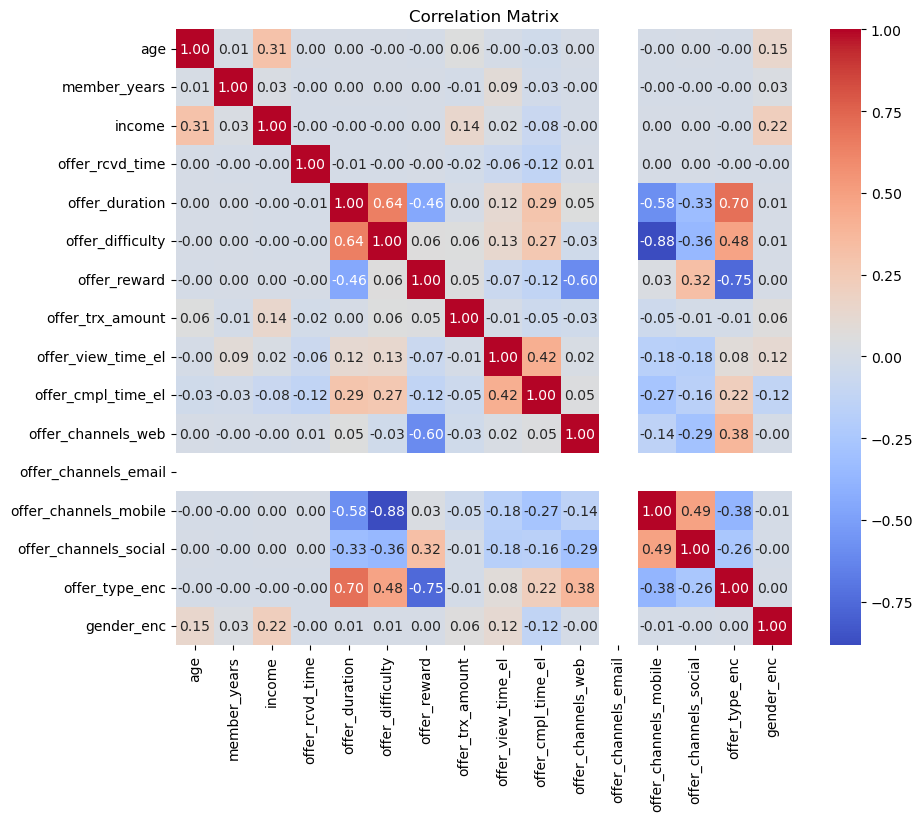

In [43]:
# Calculate the correlation matrix
correlation_matrix = offer_agg_corr.corr()

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar=True)

# Show the plot
plt.title('Correlation Matrix')
plt.show()

## Correlation of offer ids with offer_trx_amount and offer_completed

In [44]:
offer_agg_corr = offer_agg[['offer_id', 'offer_trx_amount']]

# one-hot encode offer_channels as it is a multivalue field
mapping_dict = {'ae264e3637204a6fb9bb56bc8210ddfd': 'ae',
                '4d5c57ea9a6940dd891ad53e9dbe8da0': '4d',
                '9b98b8c7a33c4b65b9aebfe6a799e6d9': '9b',
                '0b1e1539f2cc45b7b9fa7c272da2e1d7': '0b',
                '2298d6c36e964ae4a3e7e9706d1fb8c2': '22',
                'fafdcd668e3743c1bb461111dcafc2a4': 'fa',
                'f19421c1d4aa40978ebb69ca19b0e20d': 'f1',
                '2906b810c7d4411798c6938adc9daaa5': '29'}

# Replace values in the offer_id column using the mapping dictionary
offer_agg_corr.loc[:, 'offer_id'] = offer_agg_corr['offer_id'].replace(mapping_dict)

In [45]:
# One-hot encode offer_channels
offer_agg_corr = dph.one_hot_encode(offer_agg_corr, 'offer_id')

In [46]:
# Change offer_trx_amount into 1 if not NaN, else 0
offer_agg_corr['offer_compl'] = offer_agg_corr['offer_trx_amount'].notna().astype(int)
offer_agg_corr.head(10)

,offer_trx_amount,offer_id_0b,offer_id_22,offer_id_29,offer_id_4d,offer_id_9b,offer_id_ae,offer_id_f1,offer_id_fa,offer_compl
0,NaN,0,0,1,0,0,0,0,0,0
1,NaN,1,0,0,0,0,0,0,0,0
2,1.25,0,0,0,0,0,0,0,1,1
3,0.87,0,1,0,0,0,0,0,0,1
4,NaN,0,0,0,0,0,0,0,1,0
5,23.22,0,0,0,0,1,0,0,0,1
6,NaN,0,0,0,0,1,0,0,0,0
7,19.89,0,0,0,0,1,0,0,0,1
8,14.48,0,0,0,0,0,1,0,0,1
9,7.24,0,0,0,0,0,0,1,0,1


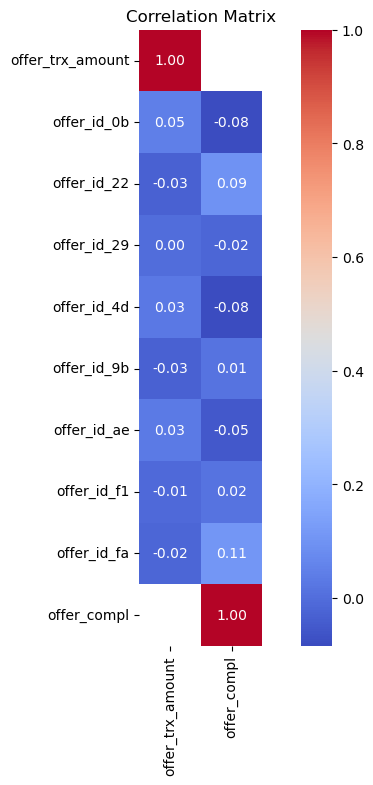

In [47]:
# Calculate the correlation matrix
correlation_matrix = offer_agg_corr.corr()

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix[['offer_trx_amount', 'offer_compl']], annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar=True)

# Show the plot
plt.title('Correlation Matrix')
plt.show()

# Prediction of offer_trx_amount, offer_compl

In [48]:
print(offer_agg.shape)

# Delete rows with NaN values gender/age/income columns
offer_agg_cleaned = offer_agg.dropna(subset=['age'])

print(offer_agg_cleaned.shape)

(61042, 20)
(53201, 20)


In [49]:
# One-hot encode offer_channels as it is a multivalue field
offer_agg_cleaned = dph.split_strlist_into_cols(offer_agg_cleaned, 'offer_channels')

In [50]:
# One-hot encode categorial values: offer_type
offer_agg_cleaned = dph.one_hot_encode(offer_agg_cleaned, 'offer_type')

In [51]:
# One-hot encode categorial values:  gender
offer_agg_cleaned = dph.one_hot_encode(offer_agg_cleaned, 'gender')

In [52]:
offer_agg_cleaned = offer_agg_cleaned[['age', 'income', 'member_years',
       'offer_difficulty', 'offer_reward',
       'offer_trx_amount', 'offer_channels_web',
       'offer_channels_email', 'offer_channels_mobile',
       'offer_channels_social', 'offer_type_bogo', 'offer_type_discount',
       'gender_F', 'gender_M', 'gender_O']]

In [53]:
offer_agg_cleaned.head(15)

,age,income,member_years,offer_difficulty,offer_reward,offer_trx_amount,offer_channels_web,offer_channels_email,offer_channels_mobile,offer_channels_social,offer_type_bogo,offer_type_discount,gender_F,gender_M,gender_O
5,55.0,112000.0,1,5,5,23.22,1,1,1,0,1,0,1,0,0
7,75.0,100000.0,1,5,5,19.89,1,1,1,0,1,0,1,0,0
8,75.0,100000.0,1,10,10,14.48,0,1,1,1,1,0,1,0,0
9,75.0,100000.0,1,5,5,7.24,1,1,1,1,1,0,1,0,0
13,68.0,70000.0,0,10,2,NaN,1,1,1,0,0,1,0,1,0
14,68.0,70000.0,0,5,5,6.14,1,1,1,0,1,0,0,1,0
15,68.0,70000.0,0,10,2,12.28,1,1,1,1,0,1,0,1,0
25,65.0,53000.0,0,5,5,9.54,1,1,1,1,1,0,0,1,0
26,65.0,53000.0,0,5,5,NaN,1,1,1,0,1,0,0,1,0
27,65.0,53000.0,0,10,2,10.42,1,1,1,0,0,1,0,1,0


In [54]:
# Split the data
X = offer_agg_cleaned.drop(columns='offer_trx_amount')
y = offer_agg_cleaned[['offer_trx_amount']].notna().astype(int)

In [55]:
X

,age,income,member_years,offer_difficulty,offer_reward,offer_channels_web,offer_channels_email,offer_channels_mobile,offer_channels_social,offer_type_bogo,offer_type_discount,gender_F,gender_M,gender_O
5,55.0,112000.0,1,5,5,1,1,1,0,1,0,1,0,0
7,75.0,100000.0,1,5,5,1,1,1,0,1,0,1,0,0
8,75.0,100000.0,1,10,10,0,1,1,1,1,0,1,0,0
9,75.0,100000.0,1,5,5,1,1,1,1,1,0,1,0,0
13,68.0,70000.0,0,10,2,1,1,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61037,83.0,50000.0,2,10,10,1,1,1,1,1,0,1,0,0
61038,83.0,50000.0,2,5,5,1,1,1,0,1,0,1,0,0
61039,83.0,50000.0,2,10,10,0,1,1,1,1,0,1,0,0
61040,62.0,82000.0,1,7,3,1,1,1,1,0,1,1,0,0


In [56]:
y

,offer_trx_amount
5,1
7,1
8,1
9,1
13,0
...,...
61037,1
61038,1
61039,1
61040,1


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [58]:
# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the classifier using the training data
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy of the model: 0.65
              precision    recall  f1-score   support

           0       0.56      0.60      0.58      5370
           1       0.72      0.68      0.70      7931

    accuracy                           0.65     13301
   macro avg       0.64      0.64      0.64     13301
weighted avg       0.66      0.65      0.65     13301



In [60]:
offer_agg[offer_agg['person'] == 'e2127556f4f64592b11af22de27a7932']

,gender,age,became_member_on,income,age_group,income_range,member_years,person,offer_rcvd_time,offer_id,offer_type,offer_channels,offer_duration,offer_difficulty,offer_reward,offer_trx_amount,offer_cmpl_time,offer_view_time,offer_view_time_el,offer_cmpl_time_el
13,M,68.0,2018-04-26,70000.0,68-77,50000-74999,0,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,discount,"['web', 'email', 'mobile']",7,10,2,NaN,NaN,NaN,NaN,NaN
14,M,68.0,2018-04-26,70000.0,68-77,50000-74999,0,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,"['web', 'email', 'mobile']",7,5,5,6.14,522.0,420.0,12.0,114.0
15,M,68.0,2018-04-26,70000.0,68-77,50000-74999,0,e2127556f4f64592b11af22de27a7932,504,fafdcd668e3743c1bb461111dcafc2a4,discount,"['web', 'email', 'mobile', 'social']",10,10,2,12.28,522.0,522.0,18.0,18.0
